In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bandit import Bandits_final

In [2]:
np.random.seed(123)

In [3]:
def decaying_epsilon_greedy(mab, num_steps=5000, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.001, alpha=-1):
    k = mab.k  # number of actions
    Q = np.zeros(k)  # estimated values for each action
    N = np.zeros(k)  # number of times each action was taken

    rewards = []

    epsilon = epsilon_start

    for episode in range(1, num_steps + 1):
        if np.random.rand() < epsilon:
            action = np.random.randint(0, k)  # exploration
        else:
            action = np.argmax(Q)  # exploitation

        _, reward, _, _, _ = mab.step(action)

        rewards.append(reward)

        N[action] += 1
        # if alpha is -1, the step size is dynamic, averaging the rewards;
        # with constant alpha, each reward has equal weight, with increased response to recent rewards.
        step_size = 1 / N[action] if alpha == -1 else alpha
        Q[action] += step_size * (reward - Q[action])

        epsilon = max(epsilon_min, epsilon_decay * epsilon)

    return rewards

In [4]:
def run_bandit_simulation(num_runs=500, num_steps=5000, alpha=-1):
    avg_reward = np.zeros(num_steps)

    for run in range(num_runs):
        mab = Bandits_final()
        rewards = decaying_epsilon_greedy(mab, alpha=alpha)
        avg_reward += rewards

    avg_reward /= num_runs
    return avg_reward

In [5]:
step_sizes = [-1, 0.01, 0.25, 0.5]
weighted_avg_rewards = [run_bandit_simulation(alpha=step_size) for step_size in step_sizes]

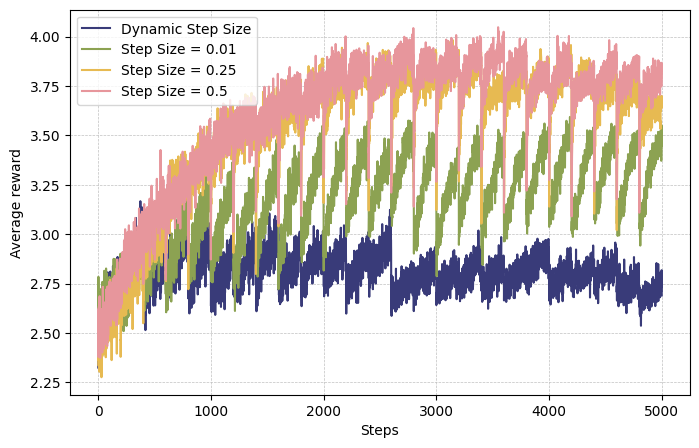

In [114]:
cmap = plt.get_cmap("tab20b")

plt.figure(figsize=(8, 5))

for i, step_size in enumerate(step_sizes):
    label = "Dynamic Step Size" if step_size == -1 else f"Step Size = {step_size}"
    plt.plot(weighted_avg_rewards[i], label=label, color=cmap(i / len(step_sizes)))

plt.ylabel("Average reward")
plt.xlabel("Steps")
plt.legend()
plt.grid(color="silver", linestyle='--', linewidth=0.5)
plt.show()